# Example 2: Solar + Battery Energy Management

## Problem Overview

**Scenario**: You have a home with solar panels, battery storage, grid connection, and varying load demand over 24 hours.

**Question**: How should you operate the battery to minimize electricity cost?

**Learning Objectives**:
- Formulate multi-component energy system optimization
- Model power balance constraints
- Handle bidirectional battery (charge/discharge)
- Maximize self-consumption of solar energy

## 1. Setup and Imports

In [ ]:
# Install CasADi if needed (uncomment if running for first time)
# !pip install casadi numpy matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

# Set random seed for reproducibility
np.random.seed(42)

print(f"CasADi loaded successfully")

CasADi loaded successfully


## 2. Configure Plot Style

In [2]:
# BelkX color palette
BELKX_BLUE = '#0079C1'
BELKX_GRAY = '#6B7280'
BELKX_ORANGE = '#F59E0B'
BELKX_GREEN = '#10B981'
BELKX_RED = '#EF4444'
BELKX_YELLOW = '#FBBF24'

# Configure matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'figure.dpi': 100,
    'lines.linewidth': 2.5,
})

%matplotlib inline

## 3. System Parameters

In [3]:
# Time horizon
N = 24              # 24 hours
dt = 1.0            # 1 hour timesteps
time_hours = np.arange(N)

# Battery parameters (Tesla Powerwall specifications)
E_bat_cap = 13.5    # Battery capacity (kWh)
P_bat_max = 5.0     # Max battery power (kW)
eta_charge = 0.95   # Charging efficiency
eta_discharge = 0.95 # Discharge efficiency
SoC_init = 0.5      # Initial 50%

# Grid parameters
P_grid_max = 20.0   # Grid connection limit (kW)

print(f"System Specifications:")
print(f"  Solar: 5 kW peak")
print(f"  Battery: {E_bat_cap} kWh capacity")
print(f"  Battery power: ±{P_bat_max} kW")
print(f"  Grid limit: {P_grid_max} kW")
print(f"  Battery efficiency: {eta_charge*100:.0f}% (charge), {eta_discharge*100:.0f}% (discharge)")
print(f"  Initial SoC: {SoC_init*100:.0f}%")

System Specifications:
  Solar: 5 kW peak
  Battery: 13.5 kWh capacity
  Battery power: ±5.0 kW
  Grid limit: 20.0 kW
  Battery efficiency: 95% (charge), 95% (discharge)
  Initial SoC: 50%


## 4. Generate Realistic 24-Hour Profiles

In [4]:
# Solar generation profile (kW) - typical 5kW residential system
solar_profile = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  # 12AM-6AM: Night
    0.2, 0.8, 1.8, 2.9, 4.0, 4.8,  # 6AM-12PM: Morning rise
    5.0, 4.9, 4.5, 3.8, 2.8, 1.5,  # 12PM-6PM: Afternoon decline
    0.5, 0.1, 0.0, 0.0, 0.0, 0.0   # 6PM-12AM: Evening/night
])

# Household load demand (kW)
load_profile = np.array([
    0.5, 0.4, 0.4, 0.4, 0.4, 0.6,  # 12AM-6AM: Night (minimal)
    1.2, 2.0, 2.5, 2.0, 1.5, 1.8,  # 6AM-12PM: Morning peak
    2.0, 2.2, 2.0, 2.5, 3.5, 4.0,  # 12PM-6PM: Afternoon rise
    3.8, 3.0, 2.0, 1.5, 1.0, 0.7   # 6PM-12AM: Evening peak, bedtime
])

# Electricity prices ($/kWh) - time-of-use pricing
price_profile = np.array([
    0.10, 0.10, 0.10, 0.10, 0.10, 0.12,  # 12AM-6AM: Off-peak
    0.15, 0.18, 0.22, 0.20, 0.18, 0.20,  # 6AM-12PM: Morning rise
    0.25, 0.25, 0.25, 0.28, 0.30, 0.35,  # 12PM-6PM: Afternoon peak
    0.38, 0.35, 0.28, 0.22, 0.15, 0.12   # 6PM-12AM: Evening peak, decline
])

print("\nDaily Totals:")
print(f"  Solar generation: {np.sum(solar_profile):.1f} kWh")
print(f"  Load consumption: {np.sum(load_profile):.1f} kWh")
print(f"  Net demand: {np.sum(load_profile - solar_profile):.1f} kWh (to be met by grid/battery)")


Daily Totals:
  Solar generation: 37.6 kWh
  Load consumption: 41.9 kWh
  Net demand: 4.3 kWh (to be met by grid/battery)


## 5. Visualize Input Data

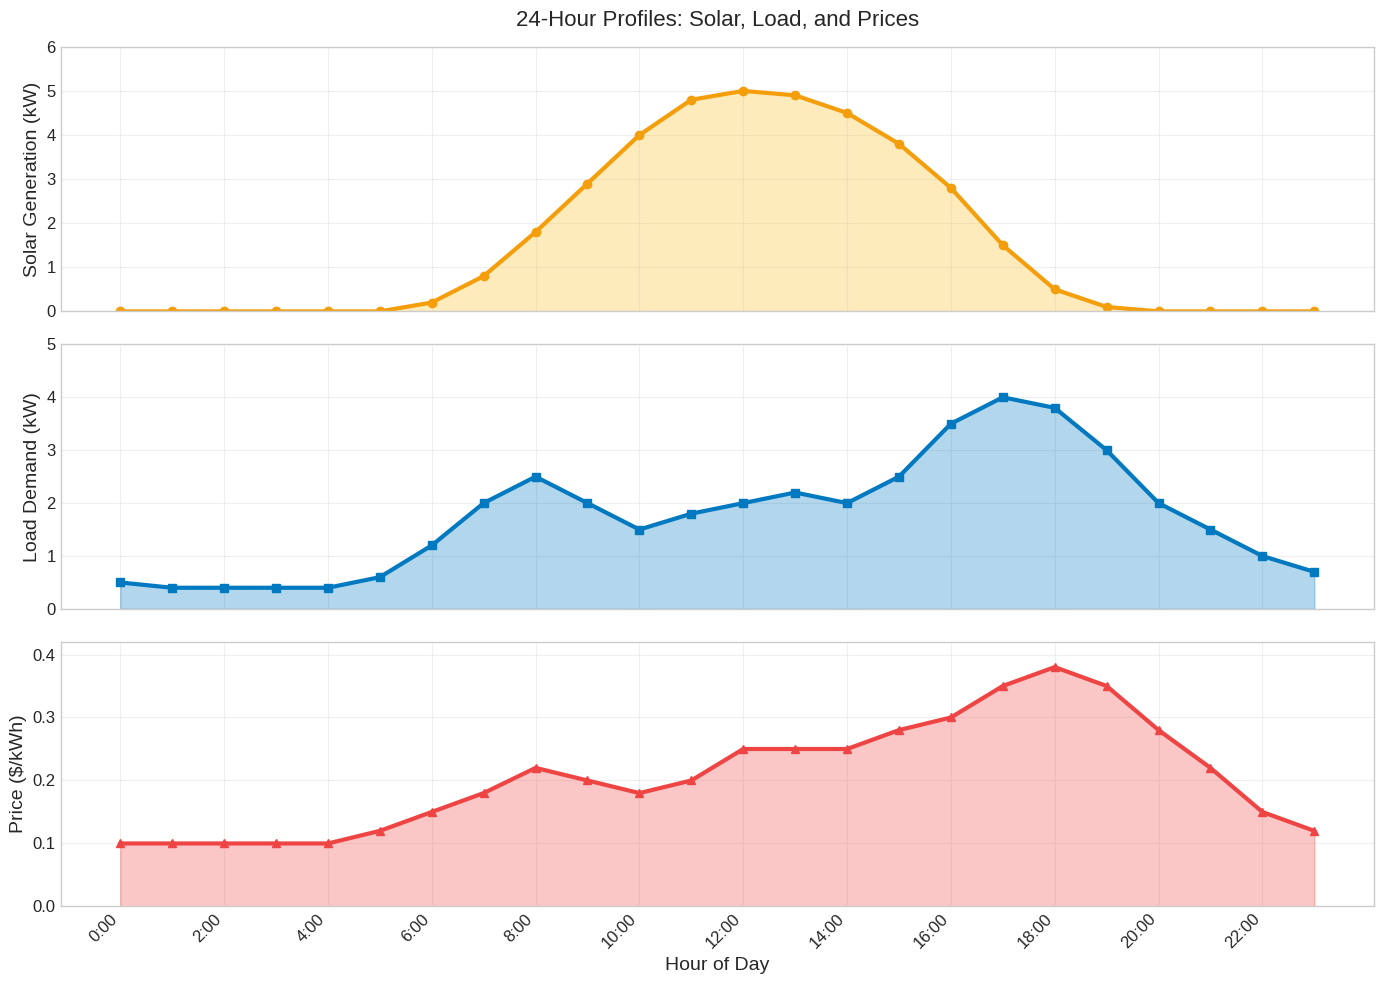


Key Observation:
  Solar peaks at noon, but evening load peak (6-7 PM) has NO solar + highest prices!
  Battery can shift solar energy to evening → reduce grid imports during expensive hours


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Solar generation
axes[0].fill_between(time_hours, 0, solar_profile, alpha=0.3, color=BELKX_YELLOW)
axes[0].plot(time_hours, solar_profile, color=BELKX_ORANGE, linewidth=3, marker='o', markersize=6)
axes[0].set_ylabel('Solar Generation (kW)', fontsize=14)
axes[0].set_title('24-Hour Profiles: Solar, Load, and Prices', fontsize=16, pad=15)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 6)

# Load demand
axes[1].fill_between(time_hours, 0, load_profile, alpha=0.3, color=BELKX_BLUE)
axes[1].plot(time_hours, load_profile, color=BELKX_BLUE, linewidth=3, marker='s', markersize=6)
axes[1].set_ylabel('Load Demand (kW)', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 5)

# Electricity prices
axes[2].fill_between(time_hours, 0, price_profile, alpha=0.3, color=BELKX_RED)
axes[2].plot(time_hours, price_profile, color=BELKX_RED, linewidth=3, marker='^', markersize=6)
axes[2].set_ylabel('Price ($/kWh)', fontsize=14)
axes[2].set_xlabel('Hour of Day', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 0.42)

for ax in axes:
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45, ha='right')

plt.tight_layout()
# plt.savefig('../public/slides/intro-optimization-mpc-workshop/solar-battery-inputs.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nKey Observation:")
print("  Solar peaks at noon, but evening load peak (6-7 PM) has NO solar + highest prices!")
print("  Battery can shift solar energy to evening → reduce grid imports during expensive hours")

## 6. Problem Formulation

### Decision Variables
- $P_{\text{bat}}^t$: Battery power at time $t$ (positive = charge, negative = discharge)
- $P_{\text{grid}}^t$: Grid power at time $t$ (positive = import)
- $E_{\text{bat}}^t$: Battery energy (state of charge)

### Objective Function
Minimize total grid electricity cost:

$$\min \sum_{t=0}^{N-1} \text{price}_t \cdot P_{\text{grid}}^t \cdot \Delta t$$

### Power Balance Constraint
At each timestep, power must balance:

$$P_{\text{solar}}^t + P_{\text{grid}}^t = P_{\text{load}}^t + P_{\text{bat}}^t$$

### Battery Dynamics
With charge/discharge efficiency:

$$E_{\text{bat}}^{t+1} = E_{\text{bat}}^t + E_{\text{charge}}^t - E_{\text{discharge}}^t$$

where:
- $E_{\text{charge}}^t = \max(0, P_{\text{bat}}^t) \cdot \Delta t \cdot \eta_{\text{charge}}$
- $E_{\text{discharge}}^t = \max(0, -P_{\text{bat}}^t) \cdot \Delta t / \eta_{\text{discharge}}$

### Constraints
- Battery power: $-P_{\text{bat,max}} \leq P_{\text{bat}}^t \leq P_{\text{bat,max}}$
- Battery energy: $0 \leq E_{\text{bat}}^t \leq E_{\text{bat,cap}}$
- Grid power: $0 \leq P_{\text{grid}}^t \leq P_{\text{grid,max}}$ (no export for simplicity)
- Cyclic: $E_{\text{bat}}^N \geq E_{\text{bat}}^0$ (end with same or more energy)

## 7. CasADi Implementation

In [8]:
# Create optimization problem
opti = Opti()

# Decision variables
P_bat = opti.variable(N)        # Battery power (positive = charge)
P_grid = opti.variable(N)       # Grid power (positive = import)
E_bat = opti.variable(N+1)      # Battery energy

print("Optimization problem created")
print(f"Decision variables: {N} + {N} + {N+1} = {3*N+1}")

Optimization problem created
Decision variables: 24 + 24 + 25 = 73


In [9]:
# Objective: minimize grid cost
grid_cost = 0
for t in range(N):
    grid_cost += price_profile[t] * P_grid[t] * dt

opti.minimize(grid_cost)
print("Objective function set: minimize grid electricity cost")

Objective function set: minimize grid electricity cost


In [10]:
# Power balance constraint at each timestep
# Solar + Grid = Load + Battery
for t in range(N):
    opti.subject_to(
        solar_profile[t] + P_grid[t] == load_profile[t] + P_bat[t]
    )

print(f"Added {N} power balance constraints")

Added 24 power balance constraints


In [11]:
# Grid constraints (only import, no export)
opti.subject_to(opti.bounded(0, P_grid, P_grid_max))

# Battery power constraints
opti.subject_to(opti.bounded(-P_bat_max, P_bat, P_bat_max))

print("Grid and battery power limits set")

Grid and battery power limits set


In [12]:
# Battery dynamics with efficiency
opti.subject_to(E_bat[0] == SoC_init * E_bat_cap)

for t in range(N):
    # Separate charge and discharge with efficiency
    E_charge = fmax(0, P_bat[t]) * dt * eta_charge
    E_discharge = fmax(0, -P_bat[t]) * dt / eta_discharge
    
    opti.subject_to(
        E_bat[t+1] == E_bat[t] + E_charge - E_discharge
    )

# Battery capacity constraints
opti.subject_to(opti.bounded(0, E_bat, E_bat_cap))

# Cyclic constraint (end at same SoC)
opti.subject_to(E_bat[N] >= SoC_init * E_bat_cap)

print(f"Battery dynamics modeled with {N+1} state updates")
print("Cyclic constraint ensures battery returns to initial state")

Battery dynamics modeled with 25 state updates
Cyclic constraint ensures battery returns to initial state


## 8. Initial Guess

In [13]:
# Provide initial guess
opti.set_initial(P_bat, 0)
opti.set_initial(P_grid, load_profile - solar_profile)  # Assume no battery initially
opti.set_initial(E_bat, SoC_init * E_bat_cap)

print("Initial guess provided (no battery usage)")

Initial guess provided (no battery usage)


## 9. Solve Optimization

In [14]:
# Configure solver
p_opts = {"expand": True}
s_opts = {"max_iter": 2000, "print_level": 3, "tol": 1e-6}

opti.solver('ipopt', p_opts, s_opts)

print("\n" + "="*60)
print("Solving optimization problem...")
print("="*60 + "\n")

try:
    sol = opti.solve()
    print("\n" + "="*60)
    print("✓ Optimization successful!")
    print("="*60)
except RuntimeError as e:
    print(f"\n✗ Solver warning, using best available solution")
    sol = opti.debug


Solving optimization problem...


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:       73
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:       74
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:       73
        inequality constraints with only upper bounds:        0


N

## 10. Extract and Analyze Results

In [15]:
# Extract optimal solution
P_bat_opt = sol.value(P_bat)
P_grid_opt = sol.value(P_grid)
E_bat_opt = sol.value(E_bat)
cost_opt = sol.value(grid_cost)

print("\nOptimal Solution:")
print(f"  Grid cost: ${cost_opt:.2f}")
print(f"  Total grid import: {np.sum(P_grid_opt) * dt:.2f} kWh")
print(f"  Final battery SoC: {E_bat_opt[-1]/E_bat_cap*100:.1f}%")
print(f"  Self-consumption: {(1 - np.sum(P_grid_opt)/np.sum(load_profile))*100:.1f}%")


Optimal Solution:
  Grid cost: $1.98
  Total grid import: 8.54 kWh
  Final battery SoC: 55.5%
  Self-consumption: 79.6%


In [17]:
# Comparison scenarios

# Scenario 1: No solar, no battery
cost_no_solar_battery = np.sum(price_profile * load_profile * dt)

# Scenario 2: Solar only (no battery)
P_grid_no_battery = np.maximum(0, load_profile - solar_profile)
cost_solar_only = np.sum(price_profile * P_grid_no_battery * dt)

print("\nCost Comparison:")
print(f"  1. No solar, no battery: ${cost_no_solar_battery:.2f}")
print(f"  2. Solar only: ${cost_solar_only:.2f} (save ${cost_no_solar_battery-cost_solar_only:.2f}, {(1-cost_solar_only/cost_no_solar_battery)*100:.0f}%)")
print(f"  3. Solar + Battery (optimal): ${cost_opt:.2f} (save ${cost_no_solar_battery-cost_opt:.2f}, {(1-cost_opt/cost_no_solar_battery)*100:.0f}%)")

print(f"\n Battery adds {(1-cost_opt/cost_solar_only)*100:.0f}% additional savings on top of solar!")
print(f"   Annual savings: ${(cost_no_solar_battery - cost_opt) * 365:.0f}")


Cost Comparison:
  1. No solar, no battery: $10.72
  2. Solar only: $5.28 (save $5.44, 51%)
  3. Solar + Battery (optimal): $1.98 (save $8.74, 81%)

 Battery adds 62% additional savings on top of solar!
   Annual savings: $3189


## 11. Visualize Power Schedule

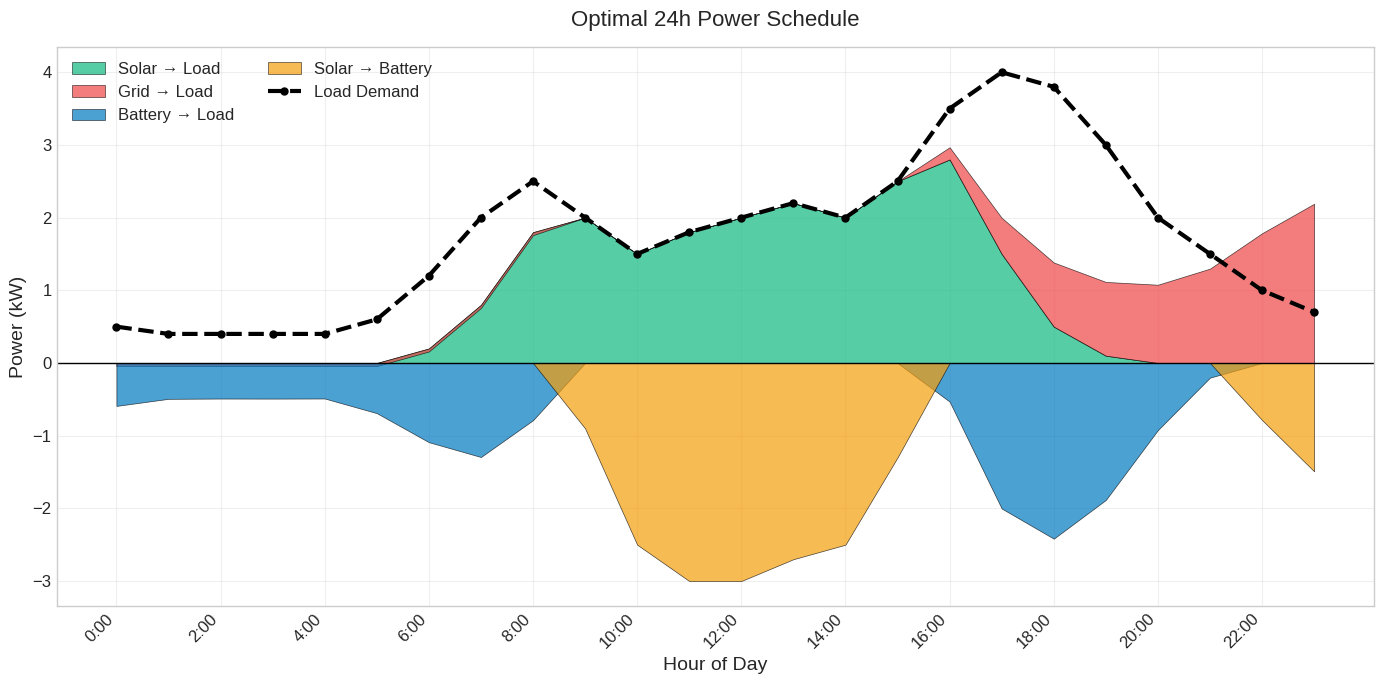


Strategy:
  Morning-Midday: Charge battery from excess solar
  Evening peak: Discharge battery (avoid high prices)
  Night: Minimal grid import (battery depleted)


In [19]:
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate power flows
P_solar_to_load = np.minimum(solar_profile, load_profile)
P_bat_discharge = np.minimum(0, P_bat_opt)
P_bat_charge = np.maximum(0, P_bat_opt)

# Create stacked area plot
bottom = np.zeros(N)

# Solar to load (green)
ax.fill_between(time_hours, bottom, bottom + P_solar_to_load,
                alpha=0.7, color=BELKX_GREEN, label='Solar → Load', edgecolor='black', linewidth=0.5)
bottom += P_solar_to_load

# Grid import (red)
ax.fill_between(time_hours, bottom, bottom + P_grid_opt,
                alpha=0.7, color=BELKX_RED, label='Grid → Load', edgecolor='black', linewidth=0.5)

# Battery discharge (blue, below zero)
ax.fill_between(time_hours, 0, P_bat_discharge,
                alpha=0.7, color=BELKX_BLUE, label='Battery → Load', edgecolor='black', linewidth=0.5)

# Battery charge (orange, below solar)
ax.fill_between(time_hours, -P_bat_charge, 0,
                alpha=0.7, color=BELKX_ORANGE, label='Solar → Battery', edgecolor='black', linewidth=0.5)

# Load demand line
ax.plot(time_hours, load_profile, color='black', linewidth=3, linestyle='--', marker='o', markersize=5, label='Load Demand')

ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Power (kW)', fontsize=14)
ax.set_title('Optimal 24h Power Schedule', fontsize=16, pad=15)
ax.legend(loc='upper left', fontsize=12, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45, ha='right')

plt.tight_layout()
# plt.savefig('../public/slides/intro-optimization-mpc-workshop/solar-battery-schedule.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nStrategy:")
print("  Morning-Midday: Charge battery from excess solar")
print("  Evening peak: Discharge battery (avoid high prices)")
print("  Night: Minimal grid import (battery depleted)")

## 12. Battery State of Charge

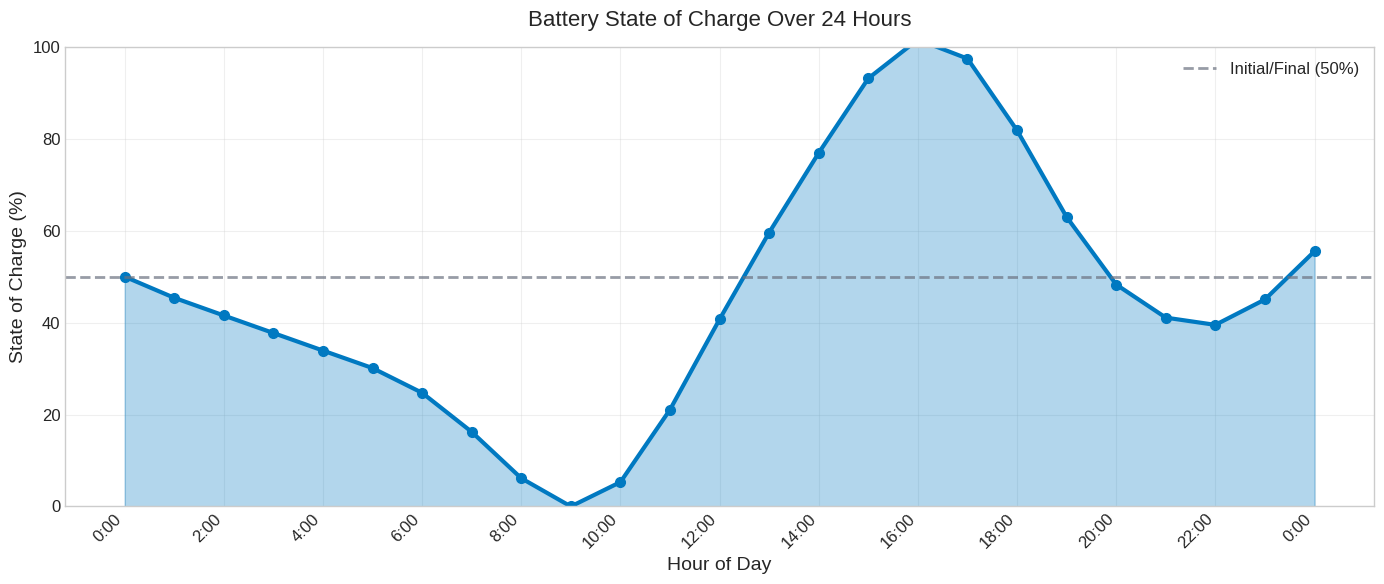


Battery utilization:
  Maximum SoC: 101.6% (hour 16)
  Minimum SoC: -0.0% (hour 9)
  Charge/discharge cycles: 1.02


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

SoC_pct = E_bat_opt / E_bat_cap * 100

ax.fill_between(np.arange(N+1), 0, SoC_pct, alpha=0.3, color=BELKX_BLUE)
ax.plot(np.arange(N+1), SoC_pct, color=BELKX_BLUE, linewidth=3, marker='o', markersize=7)
ax.axhline(SoC_init*100, color=BELKX_GRAY, linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Initial/Final ({SoC_init*100:.0f}%)')

ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('State of Charge (%)', fontsize=14)
ax.set_title('Battery State of Charge Over 24 Hours', fontsize=16, pad=15)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)
ax.set_xticks(range(0, 25, 2))
ax.set_xticklabels([f'{h%24}:00' for h in range(0, 25, 2)], rotation=45, ha='right')

# Annotate key events
max_soc_idx = np.argmax(SoC_pct)
min_soc_idx = np.argmin(SoC_pct)
ax.annotate(f'Peak: {SoC_pct[max_soc_idx]:.1f}%',
            xy=(max_soc_idx, SoC_pct[max_soc_idx]),
            xytext=(max_soc_idx-2, SoC_pct[max_soc_idx]+10),
            arrowprops=dict(arrowstyle='->', color=BELKX_GREEN, lw=2),
            fontsize=12, fontweight='bold', color=BELKX_GREEN)

plt.tight_layout()
# plt.savefig('../public/slides/intro-optimization-mpc-workshop/solar-battery-soc.png',
#             dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nBattery utilization:")
print(f"  Maximum SoC: {SoC_pct.max():.1f}% (hour {max_soc_idx})")
print(f"  Minimum SoC: {SoC_pct.min():.1f}% (hour {min_soc_idx})")
print(f"  Charge/discharge cycles: {(SoC_pct.max() - SoC_pct.min())/100:.2f}")

## 13. Key Insights

### CasADi Features Used:
-  Multiple decision variables
-  Equality constraints (power balance)
-  Inequality constraints (power limits, capacity)
-  Nonlinear expressions (`fmax` for efficiency)



**Next**: Example 3 - EV Energy Management (MPC application)